## Imports

In [ ]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models
from pathlib import Path

## Loading data

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True , transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43280598.49it/s]


Extracting ./cifar-10-python.tar.gz to .


## Training or loading trained model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet34(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)

    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

model = Model()
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ResNet34_CIFAR10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
pretrained = False
device = "cuda" if torch.cuda.is_available() else "cpu"
if MODEL_SAVE_PATH.is_file():
  model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=device))
  pretrained = True
else:
  model = Model().to(device)
[x for x,y in model.named_children()]

['base', 'drop', 'final']

In [ ]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [ ]:
best_val_acc = -1000
best_val_model = None
if not pretrained:
  for epoch in range(5):
      model.train(True)
      running_loss = 0.0
      running_acc = 0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device),labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item() * inputs.size(0)
          out = torch.argmax(outputs.detach(),dim=1)
          assert out.shape==labels.shape
          running_acc += (labels==out).sum().item()
      print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")

      correct = 0
      model.train(False)
      with torch.no_grad():
          for inputs,labels in valloader:
              out = model(inputs.to(device)).cpu()
              out = torch.argmax(out,dim=1)
              acc = (out==labels).sum().item()
              correct += acc
      print(f"Val accuracy:{correct*100/len(valset)}%")
      if correct>best_val_acc:
          best_val_acc = correct
          best_val_model = deepcopy(model.state_dict())
      lr_scheduler.step()
  torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
  print('Finished Training')

## Pruning

In [ ]:
!pip install torch-pruning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch_pruning as tp

In [ ]:
model = Model()
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=device))

criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

example_inputs = None
for data in trainloader:
  example_inputs, _ = data
  example_inputs = example_inputs.to(device)
  break
# 1. Importance criterion
imp = tp.importance.GroupTaylorImportance()

# 2. Initialize a pruner with the model and the importance criterion
ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
      ignored_layers.append(m)

pruner = tp.pruner.MetaPruner(
    model,
    example_inputs,
    global_pruning=False,
    importance=imp,
    pruning_ratio=0.3, # <== Modify the pruning ratio here
    ignored_layers=ignored_layers,
)

base_macs, base_nparams = tp.utils.count_ops_and_params(model, example_inputs)
# 3. Prune
for data in trainloader:
  inputs, labels = data
  outputs = model(inputs.to(device)).cpu()
  loss = criterion(outputs, labels)
  loss.backward()
  break
pruner.step()
macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
print(
    "  Iter %d/%d, Params: %.2f M => %.2f M"
    % (i+1, 1, base_nparams / 1e6, nparams / 1e6)
)
print(
    "  Iter %d/%d, MACs: %.2f G => %.2f G"
    % (i+1, 1, base_macs / 1e9, macs / 1e9)
)

for epoch in range(5): # <== Use 10 epochs for double retraining
    model.train()
    pruner.update_regularizer() # initialize regularizer
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        pruner.regularize(model, loss)
        optimizer.step()

#Accuracy:
correct = 0
model.train(False)
with torch.inference_mode():
    for inputs,labels in testloader:
        out = model(inputs.to(device)).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        correct += acc
print(f"Test accuracy (post-retrain): {correct*100/len(testset)}%")

  Iter 1/1, Params: 21.29 M => 10.40 M
  Iter 1/1, MACs: 3.68 G => 1.81 G


   Parameters post-pruning  Accuracy Pre-Retraining  Accuracy Post-Retraining  Accuracy Double-Retraining
0                    21.29                    95.85                     95.85                       95.85
1                    20.18                    95.34                     95.41                       94.43
2                    19.17                    93.30                     95.16                       94.33
3                    17.18                    77.08                     94.25                       94.47
4                    13.56                    53.10                     90.80                       95.08
5                    10.40                    39.86                     80.13                       94.15
6                     7.63                    11.96                     41.50                       92.30
7                     5.33                    10.25                     37.93                       92.52


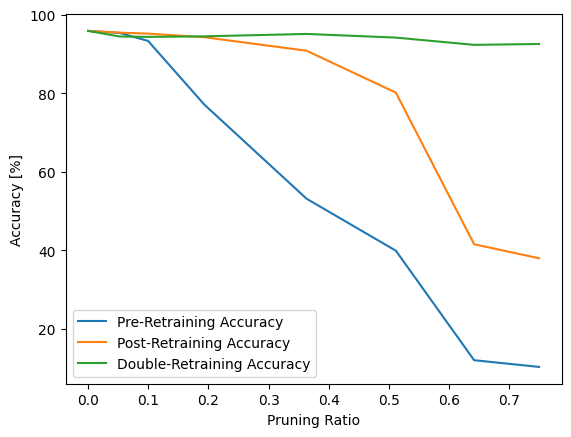

In [ ]:
# Results can be checked in the cell above.
# The actual pruning ratios are 1-(number of parameters after pruning)/(number of parameters before pruning)
df = pd.read_csv('ResNet34_data.csv')
print(df.to_string())
initial_parameters = 21.29 #Number of parameters in ResNet34 on CIFAR-10 without pruning [in million]
pruned_params = df["Parameters post-pruning"] #Number of parameters in ResNet34 on CIFAR-10 after pruning [in million] - Using "pruning_ratio": [0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
pruning_ratios = [1-x/initial_parameters for x in pruned_params]
pre_accuracies = df["Accuracy Pre-Retraining"] #Before retraining
post_accuracies = df["Accuracy Post-Retraining"] #After retraining (5 epochs)
double_retrain_accuracies = df["Accuracy Double-Retraining"] #After retraining twice
plt.plot(pruning_ratios, pre_accuracies, label="Pre-Retraining Accuracy")
plt.plot(pruning_ratios, post_accuracies, label="Post-Retraining Accuracy")
plt.plot(pruning_ratios, double_retrain_accuracies, label="Double-Retraining Accuracy")
plt.ylabel("Accuracy [%]")
plt.xlabel("Pruning Ratio")
plt.legend()